In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# --- 1. Initialization ---
# Base Station (BS) positions
bs_a_pos = np.array([0, 0])
bs_b_pos = np.array([2000, 0]) # 2000 meters apart on the x-axis

# User mobility parameters
start_pos = np.array([-500, 200])
end_pos = np.array([2500, 200])
user_velocity = 15  # meters per second (e.g., a car)
sim_time = (np.linalg.norm(end_pos - start_pos) / user_velocity) # Total time to traverse the path
time_step = 0.5 # seconds

# Signal propagation parameters
p_tx_dbm = 40.0  # Transmit power in dBm
path_loss_n = 2.8 # Path loss exponent for an urban environment
ref_distance = 1.0 # Reference distance in meters

# Handoff parameters
hysteresis_margin_db = 3.0

# --- Helper function for RSS calculation ---
def calculate_rss(distance, p_tx, n, d0):
    if distance < d0:
        distance = d0
    # Log-distance path loss model in dB
    path_loss = 10 * n * np.log10(distance / d0)
    rss = p_tx - path_loss
    return rss


In [4]:
# --- 2. Simulation Setup ---
time_points = np.arange(0, sim_time, time_step)
user_positions = [start_pos + t * user_velocity * (end_pos - start_pos) / np.linalg.norm(end_pos - start_pos) for t in time_points]

# Data logging
rss_a_log = []
rss_b_log = []
serving_cell_log = []
handoff_points = []

# Initial connection
serving_cell = 'A' if np.linalg.norm(user_positions[0] - bs_a_pos) < np.linalg.norm(user_positions[0] - bs_b_pos) else 'B'


In [5]:
# --- 3. Simulation Loop ---
for pos in user_positions:
    # a. Calculate distances
    dist_a = np.linalg.norm(pos - bs_a_pos)
    dist_b = np.linalg.norm(pos - bs_b_pos)

    # b. Calculate RSS
    rss_a = calculate_rss(dist_a, p_tx_dbm, path_loss_n, ref_distance)
    rss_b = calculate_rss(dist_b, p_tx_dbm, path_loss_n, ref_distance)

    # c. Apply Handoff Logic
    if serving_cell == 'A':
        if rss_b > rss_a + hysteresis_margin_db:
            serving_cell = 'B'
            handoff_points.append({'pos': pos[0], 'rss': rss_b})
            print(f"Handoff A -> B at position x={pos[0]:.2f} m")
    elif serving_cell == 'B':
        if rss_a > rss_b + hysteresis_margin_db:
            serving_cell = 'A'
            handoff_points.append({'pos': pos[0], 'rss': rss_a})
            print(f"Handoff B -> A at position x={pos[0]:.2f} m")

    # d. Log data
    rss_a_log.append(rss_a)
    rss_b_log.append(rss_b)
    serving_cell_log.append(1 if serving_cell == 'A' else 2) # Use numbers for plotting

Handoff A -> B at position x=1135.00 m


C:\Users\priya\AppData\Local\Temp\ipykernel_27856\314943672.py:29: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128246 (\N{ANTENNA WITH BARS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


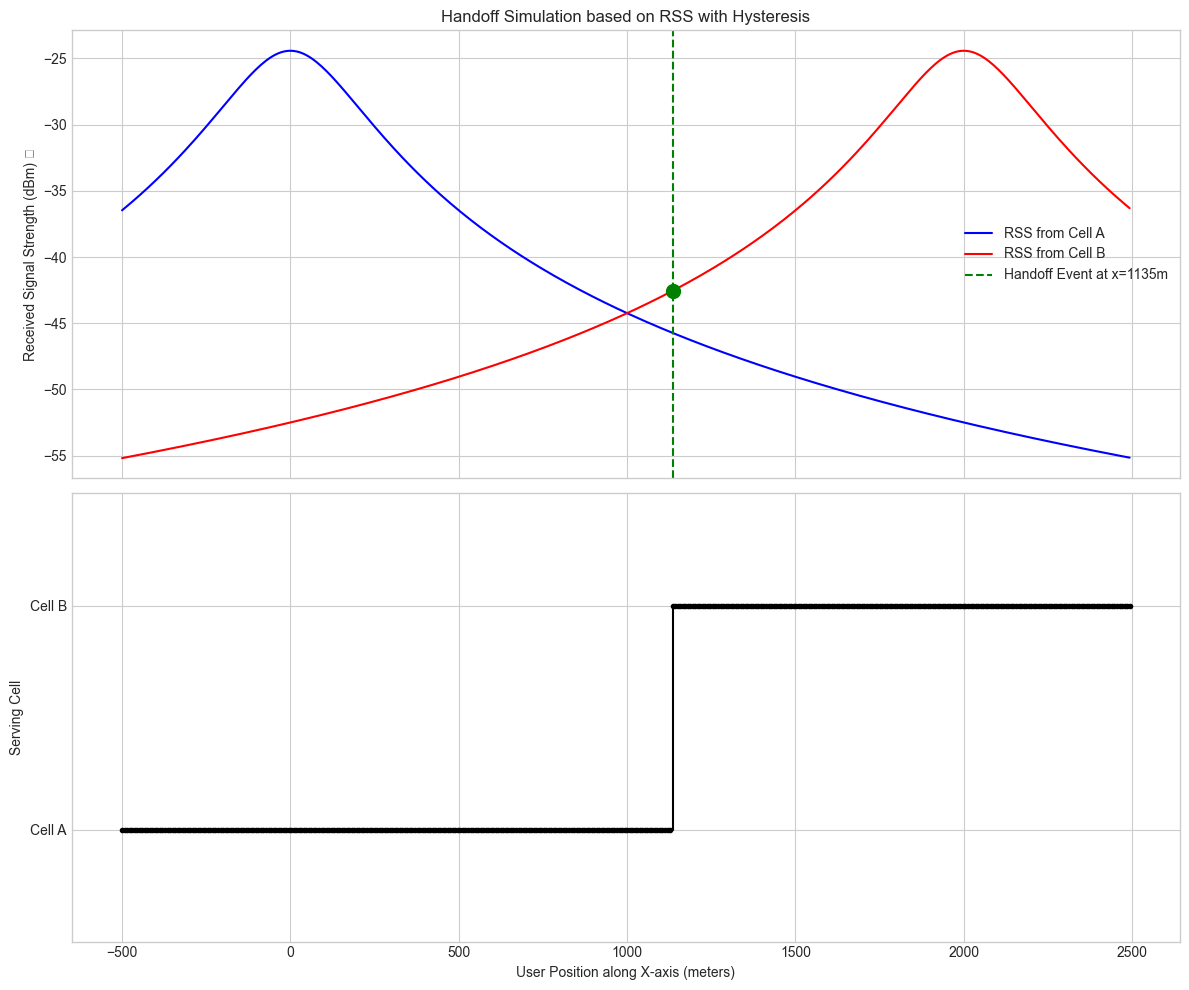

In [6]:
# --- 4. Visualization ---
user_x_positions = [p[0] for p in user_positions]

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot RSS values
ax1.plot(user_x_positions, rss_a_log, label='RSS from Cell A', color='blue')
ax1.plot(user_x_positions, rss_b_log, label='RSS from Cell B', color='red')
ax1.set_ylabel('Received Signal Strength (dBm) 📶')
ax1.set_title('Handoff Simulation based on RSS with Hysteresis')
ax1.legend()

# Mark the handoff point
for ho in handoff_points:
    ax1.axvline(x=ho['pos'], color='green', linestyle='--', label=f'Handoff Event at x={ho["pos"]:.0f}m')
    ax1.plot(ho['pos'], ho['rss'], 'go', markersize=10)
ax1.legend()


# Plot Serving Cell
ax2.plot(user_x_positions, serving_cell_log, 'k.-', drawstyle='steps-post')
ax2.set_xlabel('User Position along X-axis (meters)')
ax2.set_ylabel('Serving Cell')
ax2.set_yticks([1, 2])
ax2.set_yticklabels(['Cell A', 'Cell B'])
ax2.set_ylim(0.5, 2.5)

plt.tight_layout()
plt.show()